# Introdução

  As análises a seguir tem como objetivo criar um modelo de marchine learning para a detecção precoce de diabetes em pacientes apresentando um conjunto de sintomas. 
    
  O dataset foi adquirido pelo UCI (https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.), utilizado no estudo conduzido por Islam et al. (2019). O dataset foi montado a partir de um questionário submetido aos pacientes do Hospital de Diabetes de Sylhet, Bagladesh. No total foram consultados 520 pacientes com diabetes, ou pacientes sem diabetes porém apresentando alguns dos sintomas da doença. 
    
  O caderno está organizado desta forma:
    
   * Importando e analisando o dataset
   * Visualização simples do dataset com seaborn
   * Treinamento do modelo com sklearn
   * Redução de features e visualização da decision tree   
   
    

In [1]:
# Importando todos os pacotes/módulos/bibliotecas que serão utilizados ao longo od caderno

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn import svm, tree
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn.preprocessing import LabelEncoder

import os
from dtreeviz.trees import *


In [2]:
# fazendo o upload e visualizando o dataset

diabetes = pd.read_csv("~/Downloads/diabetes_data_upload.csv")
diabetes

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [3]:
#Para verificar se o dataframe possui lacunas, podemos usar o método .info() do pandas.
#O resultado a seguir mostra que todos os dados estão preenchidos (compare o número de non-null com o total de linhas do dataframe), e o tipo de dado

diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

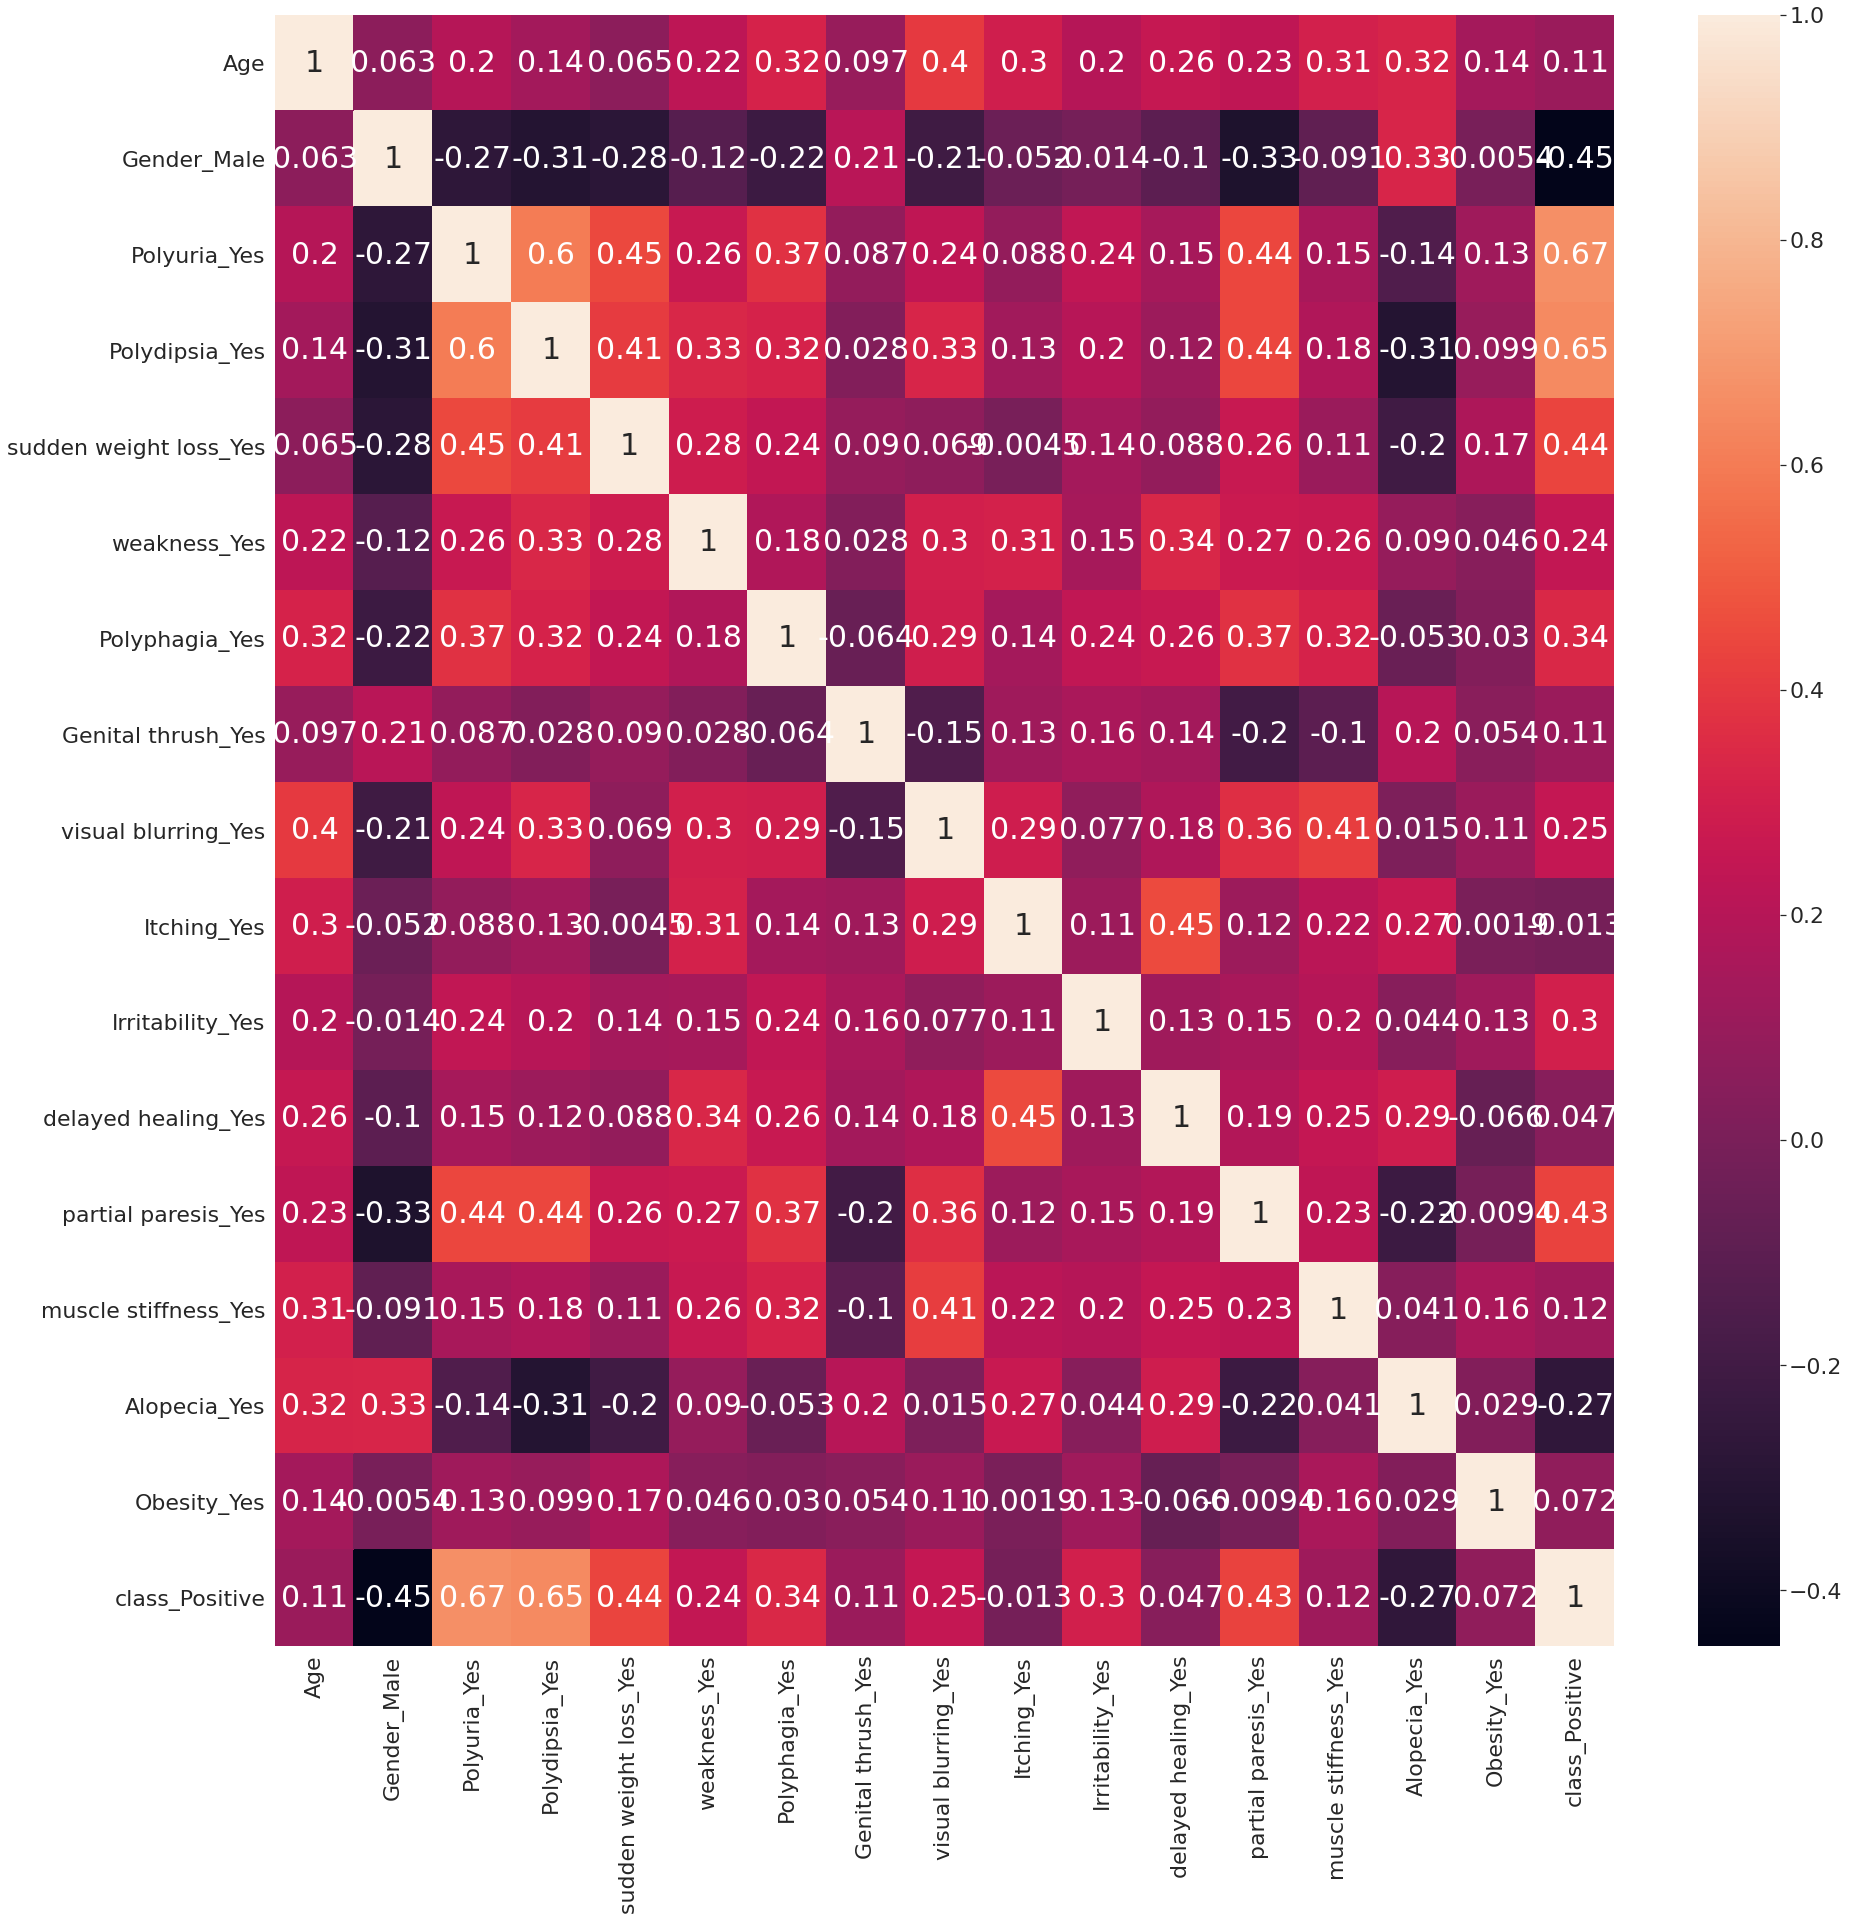

In [31]:
#Heatmap do seaborn mostra um mapa de correlação entre as features do dataframe, utilizando cores e números (de -1 a 1).
#Função .corr() transforma os dados brutos da matriz em uma matriz triangular de correlação (Pearson)
plt.figure(figsize = (30, 30))
sns.set(font_scale = 2)
sns.heatmap(pd.get_dummies(diabetes, drop_first = True).corr(), annot = True,  annot_kws={'size':30})
plt.show()

In [5]:
#Usando a função do pandas get_dummies() para transformar as variáveis categóricas em 0 e 1.

X = pd.get_dummies(diabetes.iloc[:, :-1], drop_first = True)
y = diabetes['class']

print(X.shape, y.shape)

(520, 16) (520,)


## Treinando o modelo

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [7]:
print(X_train.shape, X_test.shape)

(364, 16) (156, 16)


In [8]:
dt = DecisionTreeClassifier(random_state = 1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [34]:
acc_dt = metrics.accuracy_score(y_pred, y_test)
f1_dt = metrics.f1_score(y_pred, y_test, average = 'macro')
print("Accuracy:",acc_dt, ",", "F1:", f1_dt)

Accuracy: 0.9807692307692307 , F1: 0.9791879752746031


  Podemos ver que um modelo simples como o decision tree foi suficiente para atingir um nível de acurácia próximo aos 100%. Visto que este modelo recebe 16 variáveis/features, podemos então a partir deste resultado diminuir o input necessário para que o modelo performe quase tão bem quanto o anterior.

In [19]:
#O módulo feature_selection do sklearn nos fornece diversas ferramentas para seleção de features ou redução de dimensionalidade.
#Utilizei então o Recursive feature elimination (RFE()), que de forma simplificada, remove as features de menor importância para o modelo, de acordo com um número indicado pelo usuário.
#Com o argumento n_features_to_select podemos escolher o número de features finais.

estimator = DecisionTreeClassifier()
selector = RFE(estimator, n_features_to_select = 5, step = 1)
selector = selector.fit(X, y)
selector.support_

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False])

In [20]:
#O método support_ retorna um array booleano com as features selecinadas pelo método.
#Com esta lista então criamos um loop que nos mostra quais são estas features.

for (i, j) in zip(selector.support_, list(range(0,16))):
    if i == True:
        print(X.columns[j])

Age
Gender_Male
Polyuria_Yes
Polydipsia_Yes
Alopecia_Yes


In [38]:
#Treinamos o modelo com somente 5 features, e vemos que o resultado é menos eficiente, no entanto próximo ao original.
features = ['Age', 'Gender_Male', 'Polyuria_Yes', 'Polydipsia_Yes', 'Alopecia_Yes']
X_reduzido = X[features]

X_reduzido_train, X_reduzido_test, y_train, y_test = train_test_split(X_reduzido, y, test_size = 0.3, random_state = 1)

dt_reduzido = DecisionTreeClassifier(max_depth = 4,random_state = 1)
dt_reduzido.fit(X_reduzido_train, y_train)
y_pred_reduzido = dt_reduzido.predict(X_reduzido_test)
acc_dt_reduzido = metrics.accuracy_score(y_pred_reduzido, y_test)
f1_dt_reduzido = metrics.f1_score(y_pred_reduzido, y_test, average = 'macro')
print("Accuracy:", acc_dt_reduzido,", F1:", f1_dt_reduzido)

Accuracy: 0.9230769230769231 , F1: 0.9170653907496013


No nosso caso não faria sentido diminuiro o número de features que o modelo receberia, pois todas as features são sintomas aparentes. Para outros tipos de doença talvez seja necessária um bateria de exames caros para se chegar a alguma conclusão. Com técnicas de seleção de features, o tempo e dinheiro dispendido no diagnóstico poderia ser otimizado.

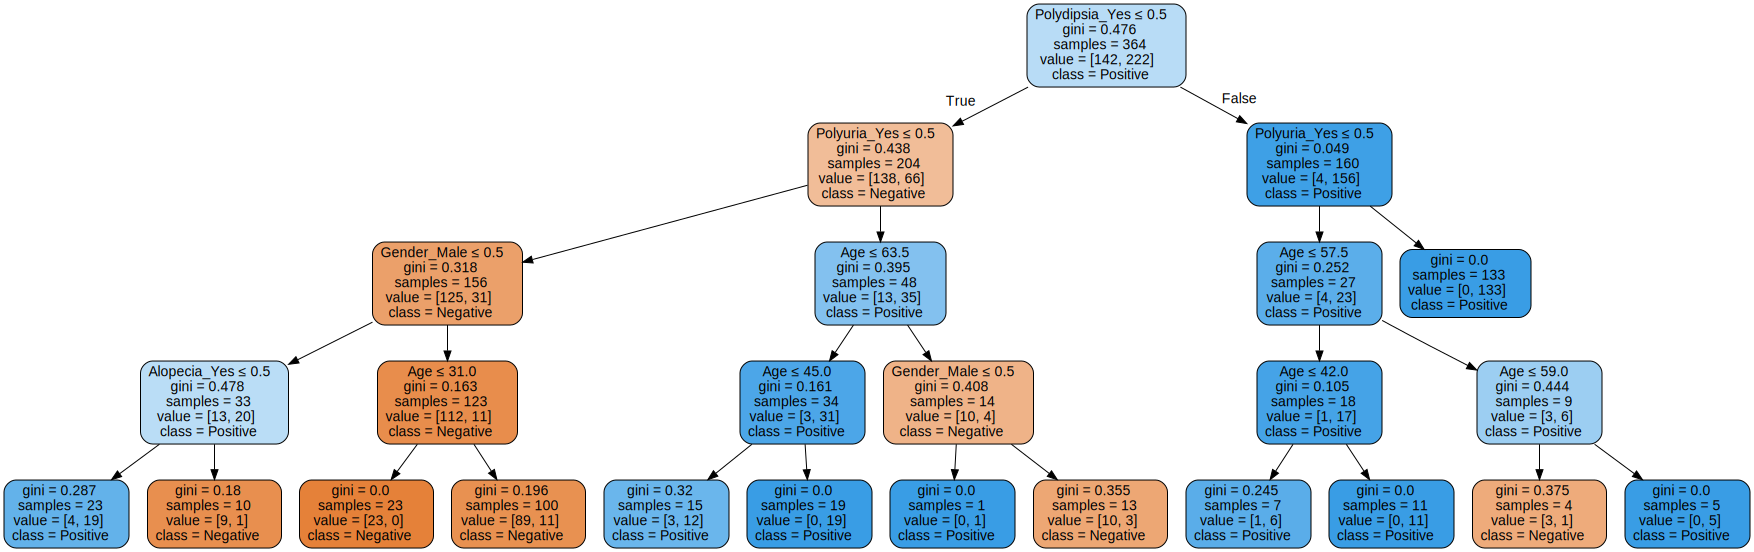

In [23]:
dot_data = tree.export_graphviz(dt_reduzido, out_file = None, feature_names = X_reduzido.columns, class_names = ['Negative', 'Positive'], filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph

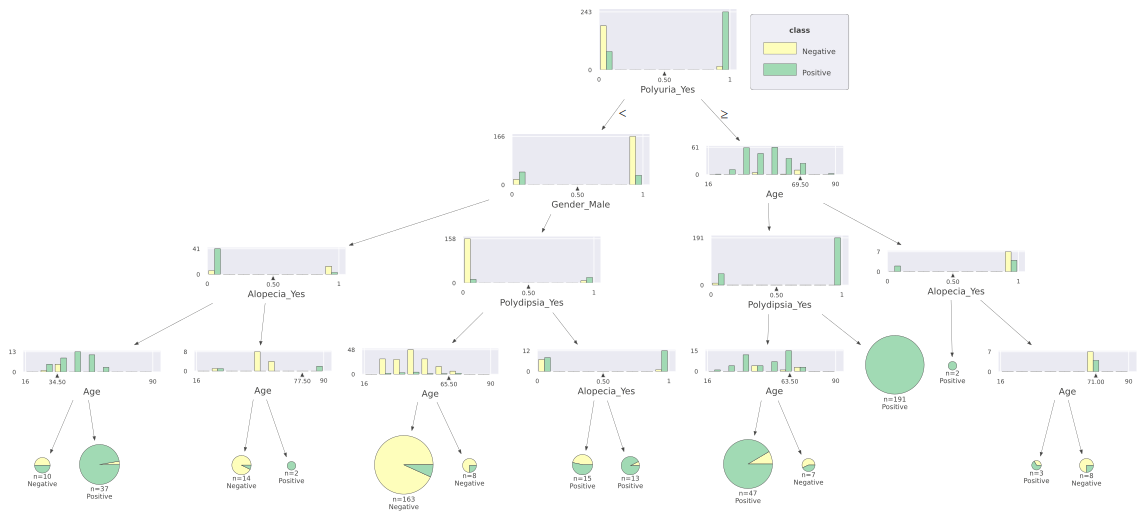

In [29]:
clas = tree.DecisionTreeClassifier(max_depth = 4)
le = preprocessing.LabelEncoder()
le.fit(y)
clas.fit(X_reduzido, le.transform(y))



viz = dtreeviz(clas, X_reduzido, le.transform(y), target_name = 'class', feature_names = X_reduzido.columns, class_names = ['Negative', 'Positive'], histtype = 'bar')
viz

In [28]:
viz.view()